<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S9/S9-T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/')

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from config import ModelConfig
from models.resnet import ResNet18
from train import train
from results import plot_misclassified_images, plot_graph
from utilities import *
from data_engine import DataEngine
#from test import test

# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

data = DataEngine(args)

Mounted at /content/gdrive/
Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout': 0.15,
  'epochs': 50,
  'l1_decay': 1e-06,
  'l2_decay': 0.001,
  'lr': 0.001,
  'num_workers': 4,
  'seed': 1}

CUDA Available
Files already downloaded and verified
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



plane   dog  deer  deer


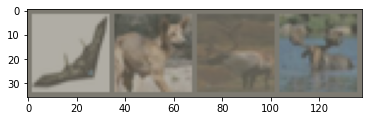

In [4]:
# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))





In [7]:
device = which_device()
net = ResNet18(args.dropout)
model = net.to(device)
show_model_summary(model, (3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

def test(model, device, test_loader, criterion, classes, test_losses, test_accs, misclassified_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind].cpu().numpy()
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    if test_acc > 85.0:
        classwise_acc(model, device, test_loader, classes)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

def classwise_acc(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    print()
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
    print()

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
  return test_losses, test_accs, misclassified_imgs, correct_imgs



Let us show some of the training images, for fun.



In [0]:
# train and test the model
test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

In [0]:
plot_graph(test_losses, "Loss")



In [0]:
plot_graph(test_accs, "Accuracy")



In [0]:
plot_misclassified_images(misclassified_imgs, data.classes, "misclassified_imgs.png")